In [2]:
from IPython.core.debugger import set_trace

import numpy as np
import scipy as sp
import scipy.optimize as optim
from scipy.optimize import minimize
from scipy.misc import factorial
from scipy.special import polygamma, expit, logit

import gdual as gd
import forward as fwd #for PGFs only

import matplotlib.pyplot as plt

In [ ]:
def objective(F_p, q_theta, k = 10):
    # construct M_p, the MGF of p
    M_p = lambda t: F_p(np.exp(t))
    
    # compute mu = the EV of n under p
    t0_gd = gd.GDual(coefs=[1,1])
    mu_p = M_p(t0_gd)
    
    # construct C_p, the Central MGF of p
    C_p = lambda t: np.exp(-mu_p * t) * M_p(t)
    
    # compute the first k central moments of p from C_p
    t0_gd = gd.GDual(coefs=[0,1], q=k)
    moments = C_p(t0_gd)
    moments = moments.unwrap_coefs(moments.coefs, as_log = False)
    moments = moments * factorial(np.arange(k+1)) # correct for the factorials
    
    # compute the first k derivatives of f_theta at a
    f_theta = lambda x: np.log(q_theta(x))

    # compute the first k derivatives of f_theta at mu
    mu_gd = gd.LSGDual(mu_p, q=k)
    derivs = f_theta(mu_gd)
    derivs = derivs.unwrap_coefs(derivs.coefs, as_log = False)
    # derivs = derivs * factorial(np.arange(k+1))
    # note: derivs already includes the actual derivatives / {0:k}!
    
    val = -np.sum(derivs * moments)

In [ ]:
theta_p = [7.0, 0.5]
F_p = lambda s: fwd.negbin_pgf(s, theta_p)

# construct M_p, the MGF of p
M_p = lambda t: F_p(np.exp(t))
    
# compute mu = the EV of n under p
t0_gd = gd.GDual(coefs=[0,1])
mu_p = M_p(t0_gd)
mu_p = mu_p.unwrap_coefs(mu_p.coefs, as_log = False)[1]

# construct C_p, the Central MGF of p
C_p = lambda t: np.exp(-mu_p * t) * M_p(t)

# test
k = 8
t0_gd = gd.GDual(coefs=[0,1], q=k)
moments = C_p(t0_gd)
moments = moments.unwrap_coefs(moments.coefs, as_log = False) * factorial(np.arange(k+1))

print(moments)

# theta_q = 3.0
# q_theta = the pmf of the approximating distribution
# q_theta = lambda x, lmbda: ((lmbda ** x) * np.exp(-lmbda)) / factorial(x)

a = mu_p

##### for a normal
#mu_q = 4.0
#sigma_q = 1.0
#q_theta = lambda x: (1.0 / (2.0 * np.pi * (sigma_q ** 2)) ** 0.5) * np.exp(-(((x - mu_q)**2) / (2.0 * (sigma_q ** 2))))
#f_theta = lambda x: np.log(q_theta(x))
#
## compute the first k derivatives of f_theta at mu
#mu_gd = gd.LSGDual(mu_p, q=k)
#derivs = f_theta(mu_gd)
#derivs = derivs.unwrap_coefs(derivs.coefs, as_log = False)
## derivs = derivs * factorial(np.arange(k+1))
## note: derivs already includes the actual derivatives / {0:k}!
#print(derivs)
##### /normal

##### for a Poisson
lambda_q = 4
derivs = np.zeros(k + 1)
for i in range(k+1):
    if i == 0:
        derivs[i] = np.log(sp.stats.poisson.pmf(a, lambda_q))
    if i == 1:
        derivs[i] = a - polygamma(i - 1, a + 1)
    if i == 2:
        derivs[i] = 1 - polygamma(i - 1, a + 1)
    if i >= 3:
        derivs[i] = -polygamma(i - 1, a + 1)
print(derivs)
##### /poisson

val = -np.sum(derivs * moments)

print(val)

In [4]:
def poiss_KL_objective(F_p, theta_q, k = 2):
    # construct M_p, the MGF of p
    M_p = lambda t: F_p(np.exp(t))
    
    # compute mu = the EV of n under p
    t0_gd = gd.LSGDual(0,1)
    mu_p = M_p(t0_gd)
    mu_p = mu_p.unwrap_coefs(mu_p.coefs, as_log = False)[1]
    
    # construct C_p, the Central MGF of p
    C_p = lambda t: np.exp(-mu_p * t) * M_p(t)
    
    # compute the first k central moments of p from C_p
    t0_gd = gd.LSGDual(0, q=k)
    moments = C_p(t0_gd)
    moments = moments.unwrap_coefs(moments.coefs, as_log = False)
    moments = moments * factorial(np.arange(k+1)) # correct for the factorials
    
    a = mu_p
    
    # compute the first k derivatives of f_theta at a = mu_p
    derivs = np.zeros(k + 1)
    for i in range(k+1):
        if i == 0:
            derivs[i] = np.log(sp.stats.poisson.pmf(a, theta_q))
        if i == 1:
            derivs[i] = np.log(theta_q) - polygamma(i - 1, a + 1)
#         if i == 2:
#             derivs[i] = 1 - polygamma(i - 1, a + 1)
        if i >= 2:
            derivs[i] = -polygamma(i - 1, a + 1)
    
    val = -np.sum(derivs * moments)
    
    return(val)

def negbin_KL_objective(F_p, theta_q, k = 12):
    # construct M_p, the MGF of p
    M_p = lambda t: F_p(np.exp(t))
    
    # compute mu = the EV of n under p
    t0_gd = gd.LSGDual(0, 1)
    mu_p = M_p(t0_gd)
    mu_p = mu_p.unwrap_coefs(mu_p.coefs, as_log = False)[1]
    
    # construct C_p, the Central MGF of p
    C_p = lambda t: np.exp(-mu_p * t) * M_p(t)
    
    # compute the first k central moments of p from C_p
    t0_gd = gd.LSGDual(0, q=k)
    moments = C_p(t0_gd)
    moments = moments.unwrap_coefs(moments.coefs, as_log = False)
    moments = moments * factorial(np.arange(k+1)) # correct for the factorials
    
    a = mu_p
    
    # compute the first k derivatives of f_theta at a = mu_p
    derivs = np.zeros(k + 1)
    for i in range(k+1):
        if i == 0:
            derivs[i] = np.log(sp.stats.nbinom.pmf(a, n=theta_q[0], p=theta_q[1]))
        if i == 1:
            derivs[i] = polygamma(i - 1, a + theta_q[0]) - polygamma(i - 1, a + 1) + np.log(theta_q[1])
        if i >= 2:
            derivs[i] = polygamma(i - 1, a + theta_q[0]) - polygamma(i - 1, a + 1)
    
    val = -np.sum(derivs * moments)
    
    return(val)

In [ ]:
P = 'poisson'
# P = 'negbin'

Q = 'poisson'
# Q = 'negbin'
# Q_safe = True
Q_safe = False

if P is 'poisson':
    theta_p = [4.0]
    F_p = lambda s: fwd.poisson_pgf(s, theta_p)

if P is 'negbin':
    theta_p = [4.0, 0.5]
    F_p = lambda s: fwd.negbin_pgf(s, theta_p)

if Q is 'poisson':
    if Q_safe:
        obj = lambda log_x: poiss_KL_objective(F_p, np.exp(log_x))
    else:
        obj = lambda x: poiss_KL_objective(F_p, x)

if Q is 'negbin':
    if Q_safe:
        obj = lambda x: negbin_KL_objective(F_p, [np.exp(x[0]), expit(x[1])])
    else:
        obj = lambda x: negbin_KL_objective(F_p, x)

if Q is 'poisson':
    theta_opt = optim.minimize(obj, [1.0], method='BFGS', tol=1e-25, options={'disp':True})
if Q is 'negbin':
    theta_opt = optim.minimize(obj, [4.0, 0.5], method='Nelder-Mead', tol=1e-25, options={'disp':True})

if not Q_safe:
    print(theta_opt.x)
elif Q is 'poisson':
    print(np.exp(theta_opt.x))
elif Q is 'negbin':
    print([np.exp(theta_opt.x[0]), expit(theta_opt.x[1])])

x = range(20)

if P is 'poisson':
    y_true = sp.stats.poisson.pmf(x, theta_p)

if P is 'negbin':
    y_true = sp.stats.nbinom.pmf(x, n = theta_p[0], p = theta_p[1])

if Q is 'poisson':
    if Q_safe:
        Q_lambda = np.exp(theta_opt.x)
    else:
        Q_lambda = theta_opt.x
    
    y_hat = sp.stats.poisson.pmf(x, Q_lambda)

if Q is 'negbin':
    if Q_safe:
        Q_n = np.exp(theta_opt.x[0]) 
        Q_p = expit(theta_opt.x[1])
    else:
        Q_n = theta_opt.x[0]
        Q_p = theta_opt.x[1]
    
    y_hat = sp.stats.nbinom.pmf(x, n = Q_n, p = Q_p)

plt.figure()
plt.plot(y_true, label='P')
plt.plot(y_hat, label='Q', linestyle='--')
plt.legend()
plt.show()

In [ ]:
theta_opt

In [ ]:
x = range(100)

# p = sp.stats.nbinom.pmf(x, theta_p[0], theta_p[1])
# q = sp.stats.nbinom.pmf(x, theta_opt.x[0], theta_opt.x[1])

p = sp.stats.poisson.pmf(x, theta_p[0])
q = sp.stats.poisson.pmf(x, theta_opt.x[0])

y = np.sum(p * np.log(q))

print(y)

/Users/kwinner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in exp
/Users/kwinner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in exp


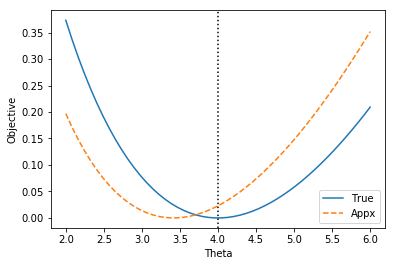

In [27]:
# P = 'poisson'
P = 'negbin'

# Q = 'poisson'
Q = 'negbin'

k = 2

if P is 'poisson':
    theta_p = [4.0]
    F_p = lambda s: fwd.poisson_pgf(s, theta_p)
    f_p = lambda x: sp.stats.poisson.pmf(x, theta_p[0])

if P is 'negbin':
    theta_p = [4.0, 0.5]
    F_p = lambda s: fwd.negbin_pgf(s, theta_p)
    f_p = lambda x: sp.stats.nbinom.pmf(x, theta_p[0], theta_p[1])
#     f_p = lambda x: sp.stats.poisson.pmf(x, theta_p[0])

if Q is 'poisson':
    theta_0 = [4.0] if P is 'negbin' else theta_p
    obj = lambda x: poiss_KL_objective(F_p, x, k = k)
    f_q = lambda x, theta: np.log(sp.stats.poisson.pmf(x, theta[0]))

if Q is 'negbin':
    theta_0 = [4.0, 0.5] if P is 'poisson' else theta_p
    obj = lambda x: negbin_KL_objective(F_p, x, k = k)
    f_q = lambda x, theta: np.log(sp.stats.nbinom.pmf(x, theta[0], theta[1]))

control_var = 0
theta_width = 0.5
theta_res = 50
theta_width = theta_width * theta_0[control_var]
theta_plot = np.linspace(theta_0[control_var] - theta_width, theta_0[control_var] + theta_width, theta_res)

x_domain = range(0, 200)

y_true_fun = lambda theta: -np.sum([f_p(x) * f_q(x, theta) for x in x_domain])
y_appx_fun = lambda theta: obj(theta)

y_true_vec = np.nan * np.ones(len(theta_plot))
y_appx_vec = np.nan * np.ones(len(theta_plot))
for i_theta in range(len(theta_plot)):
    theta_iter = np.copy(theta_0)
    theta_iter[control_var] = theta_plot[i_theta]
    
    y_true_vec[i_theta] = y_true_fun(theta_iter)
    y_appx_vec[i_theta] = y_appx_fun(theta_iter)

y_appx_vec = y_appx_vec - np.min(y_appx_vec)
y_true_vec = y_true_vec - np.min(y_true_vec)
    
plt.figure()
plt.plot(theta_plot, y_true_vec, label='True')
plt.plot(theta_plot, y_appx_vec, label='Appx', linestyle='--')
plt.axvline(x=theta_p[control_var], color='Black', linestyle=':')
plt.xlabel('Theta')
plt.ylabel('Objective')
plt.legend()
plt.show()